In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
df=pd.read_excel("Final_Neonatal data.xlsx")

In [5]:
df.shape

(3009, 44)

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [8]:
drop_cols = [
    'CardNumber', 'FullName', 'Region', 'Zone', 'Wereda', 'Kebele',
    'APGARscore','Xray', 'US', 'EchoCard', 'CTScan', 'Hepatatis',
    'Unnamed: 44', '1'
]

# Filter out columns that do not exist in the DataFrame
existing_drop_cols = [col for col in drop_cols if col in df.columns]

# Drop only the existing columns
d = df.drop(columns=existing_drop_cols)

print(f"Dropped columns: {existing_drop_cols}")
print("Remaining columns:")
print(d.columns.tolist())

Dropped columns: ['CardNumber', 'FullName', 'Region', 'Zone', 'Wereda', 'Kebele', 'APGARscore', 'Xray', 'US', 'EchoCard', 'CTScan', 'Hepatatis']
Remaining columns:
['RegistrationDate', 'Sex', 'AgeInDay', 'AgeInHour', 'Wight', 'Diagnosis', 'TotalWBC', 'Hemoglobin', 'Hematocrit', 'Platelet', 'BloodRH1', 'RBS', 'ESR', 'CRP', 'Direct', 'Indirect', 'Total', 'Na', 'Ca', 'K', 'Mg', 'ManagmentDecision', 'AgeMother', 'Gravidity', 'Parity', 'BloodRH2', 'HIV', 'GestesionalAge', 'PlaceofDeli', 'UDRL', 'DischargeDate', 'DischargeCondition']


In [9]:
d.to_excel('Final_Neonatal datanew.xlsx', index=False)

In [10]:
d=pd.read_excel('Final_Neonatal datanew.xlsx')

In [12]:
d.shape

(3009, 32)

In [13]:
# Check how many samples per class
print(d['DischargeCondition'].value_counts())

DischargeCondition
Improved    2501
Died         368
LAMA         108
Transfer      32
Name: count, dtype: int64


In [14]:
d.drop_duplicates(inplace=True)

In [15]:
print(d['DischargeCondition'].value_counts())

DischargeCondition
Improved    977
Died        149
LAMA         42
Transfer     12
Name: count, dtype: int64


In [ ]:
d.isnull().sum()

In [20]:
mode_sex = d['Sex'].mode()[0]
d['Sex'] = d['Sex'].fillna(mode_sex)

In [21]:
mode_diagnosis = d['Diagnosis'].mode()[0]
d['Diagnosis'] = d['Diagnosis'].fillna(mode_diagnosis)

In [22]:
mode_ManagmentDecision = d['ManagmentDecision'].mode()[0]
d['ManagmentDecision'] = d['ManagmentDecision'].fillna(mode_ManagmentDecision)

In [23]:
mode_ManagmentDecision = d['ManagmentDecision'].mode()[0]
d['ManagmentDecision'] = d['ManagmentDecision'].fillna(mode_ManagmentDecision)

In [24]:
mean_GestesionalAge = d['GestesionalAge'].mean()
d['GestesionalAge'] = d['GestesionalAge'].fillna(mean_GestesionalAge)

In [26]:
mean_udrl = d['UDRL'].mean()
d['UDRL'] = d['UDRL'].fillna(mean_udrl)

In [ ]:
d.isnull().sum()

In [30]:


def clinical_entropy_matched_oversample(
    d,
    target_col,
    total_size=None,
    target_entropy=1.23,
    noise_level=0.02,
    random_state=42
):

    d = d.copy()
    numeric_cols = d.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)  # avoid adding noise to target

    counts = d[target_col].value_counts()
    classes = counts.index.tolist()
    freqs = counts.values.astype(float)

    log_freqs = np.log(freqs)

    def entropy(p):
        return -np.sum(p * np.log(p + 1e-9))

    if total_size is None:
        total_size = len(df)

    if target_entropy is None:
        # maximum entropy for current number of classes
        target_entropy = np.log(len(classes))

    # Search temperature
    best_T, best_diff, best_p = None, 1e9, None
    for T in np.linspace(0.1, 5, 5000):
        logits = log_freqs / T
        p = np.exp(logits) / np.exp(logits).sum()
        diff = abs(entropy(p) - target_entropy)
        if diff < best_diff:
            best_T, best_diff, best_p = T, diff, p

    # Final target counts
    targets = dict(zip(classes, (best_p * total_size).astype(int)))

    augmented = [d]

    for cls, target_n in targets.items():
        class_df = df[df[target_col] == cls]
        n_current = len(class_df)

        if target_n <= n_current:
            continue

        n_needed = target_n - n_current
        sampled = class_df.sample(n=n_needed, replace=True, random_state=random_state).copy()

        # Add noise to numeric columns
        for col in numeric_cols:
            std = d[col].std()
            if std > 0:
                sampled[col] += np.random.normal(0, noise_level * std, size=n_needed)

        # Optional: cast integers back if original column is int
        for col in numeric_cols:
            if pd.api.types.is_integer_dtype(d[col]):
                sampled[col] = sampled[col].round().astype(df[col].dtype)

        augmented.append(sampled)

    df_aug = pd.concat(augmented, ignore_index=True)
    df_aug = df_aug.sample(frac=1, random_state=random_state).reset_index(drop=True)
    return df_aug


In [33]:
df_aug = clinical_entropy_matched_oversample(
    d,
    target_col='DischargeCondition',
    total_size=2065,
    target_entropy=1.23,
    noise_level=0.02
)

df_aug.to_excel('Final_Neonatal_data_augmentedml.xlsx', index=False)


In [ ]:
df_aug

In [35]:
df_aug = clinical_entropy_matched_oversample(
    d,
    target_col='DischargeCondition',
    total_size=2065
)

df_aug['DischargeCondition'].value_counts(normalize=True)

DischargeCondition
Improved    0.561494
Died        0.171839
LAMA        0.154023
Transfer    0.112644
Name: proportion, dtype: float64

In [36]:
print(df_aug['DischargeCondition'].value_counts())

DischargeCondition
Improved    977
Died        299
LAMA        268
Transfer    196
Name: count, dtype: int64


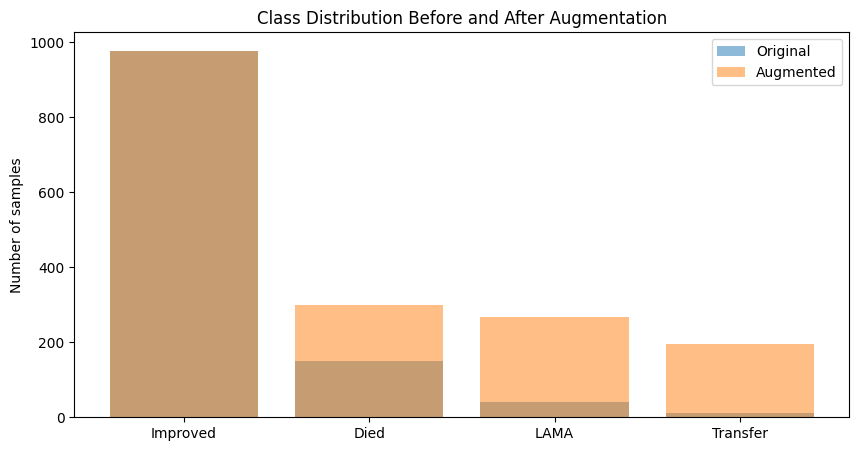

In [40]:
# Before augmentation
original_counts = d['DischargeCondition'].value_counts()

# After augmentation
aug_counts = df_aug['DischargeCondition'].value_counts()

plt.figure(figsize=(10,5))
plt.bar(original_counts.index, original_counts.values, alpha=0.5, label='Original')
plt.bar(aug_counts.index, aug_counts.values, alpha=0.5, label='Augmented')
plt.ylabel('Number of samples')
plt.title('Class Distribution Before and After Augmentation')
plt.legend()
plt.show()
